In [1]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import PIL.Image as Image
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# from torch.data

In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
def decode(Y):
    P=provinces[Y[0]]
    S=alphabets[Y[1]]
    C=[ads[y] for y in Y[2:]]
    return P+S+''.join(C)

In [5]:
import random
a=['a','b','c']
random.shuffle(a)
print(a)

['a', 'c', 'b']


### generate file for detection task(using darknet)

In [2]:
import shutil
from tqdm import tqdm
import numpy.random as npr
import random
def createDetectDataSet(src,tgt,num=None):
    imglist=glob.glob(src)
#     random.shuffle(imglist)
    if num:imglist=imglist[:num]
    def decodeBox(imgname):
#         I=cv2.imread(imgname)
#         H,W,_=I.shape
        W,H=Image.open(imgname).size
        
        basename=os.path.basename(imgname)
        sps=basename.split('-')

        bbox=sps[2]
        bbox=bbox.split('_')
        pp1=bbox[0].split('&')
        pp2=bbox[1].split('&')
        x1,y1,x2,y2=int(pp1[0]),int(pp1[1]),int(pp2[0]),int(pp2[1])
        return x1/W,y1/H,x2/W,y2/H
    for i,imgpath in tqdm(enumerate(imglist),'processing data,patient!'):
        ##open file
        
        x1,y1,x2,y2=decodeBox(imgpath)
        content=','.join(map(str,[0,x1,y1,x2,y2]))
        
        tgt_img=os.path.join(tgt,'%d.jpg'%i)
        tgt_label=os.path.join(tgt,'%d.txt'%i)
        shutil.copy(imgpath,tgt_img)
        with open(tgt_label,'w') as fs:
            fs.write(content)
def splitDataset(src,tgt,testnum=1000,prefix=''):
    imglist=glob.glob(src)
    idx=np.arange(len(imglist))
    npr.shuffle(idx)
    with open(os.path.join(tgt,'train.txt'),'w') as fs:
        for index in idx[:-testnum]:
            s=imglist[index]
            s=os.path.join(prefix,os.path.basename(s))
            fs.write(s+'\n')
    with open(os.path.join(tgt,'test.txt'),'w') as fs:
        for index in idx[-testnum:]:
            s=imglist[index]
            s=os.path.join(prefix,os.path.basename(s))
            fs.write(s+'\n')
db_src='/home/zxk/AI/data/CCPD2019/ccpd_base/*.jpg'
db_my='/home/zxk/AI/darknet/mymodel/ccpd/obj/'
db_train_test='/home/zxk/AI/darknet/mymodel/ccpd'
prefix_anno='ccpd/obj'
if os.path.exists(db_my):
    shutil.rmtree(db_my)
os.mkdir(db_my)
createDetectDataSet(db_src,db_my,num=40000)
splitDataset(db_my+'*.jpg',db_train_test,testnum=2000,prefix=prefix_anno)

processing data,patient!: 40000it [06:59, 95.31it/s] 


In [46]:
! ls /home/zxk/AI/darknet/mymodel/ccpd/

obj  obj.data  obj.names  test.txt  train.txt  yolov-obj.cfg


### Create DataSet For recognition Task(MyModel)

trainset: 179993
teset: 20000
(32, 64)
皖AGN328
torch.Size([64, 1, 32, 64]) torch.Size([64, 7])


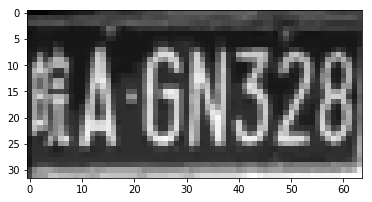

In [3]:
class CCPD_Dataset(Dataset):
    
    def __init__(self,basedir,train,seed=0):
        super().__init__()   
        db=glob.glob(basedir)
        n=len(db)
        np.random.seed(seed)
        totalidx=set(np.arange(n))
        trainidx=set(np.random.choice(n,int(n*0.9),False))
        testidx=totalidx-trainidx
        
        if train:
            self._db=[db[idx] for idx in trainidx]
        else:
            self._db=[db[idx] for idx in testidx]
        self._init_processing_fn()
    def _init_processing_fn(self):
        t1=transforms.FiveCrop((24,24))
        t2=transforms.Lambda(lambda imgs:[transforms.RandomHorizontalFlip(0.5)(img) for img in imgs])
        t3=transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop)  for crop in crops]))
        
        t_affine=transforms.RandomAffine(5,(0.05,0.05),(0.9,1.1))
        t_color=transforms.ColorJitter(brightness=.3, contrast=.3)
        t_resize=transforms.Resize((32,64))
        t_tensor=transforms.ToTensor()
        
        t_norm=transforms.Lambda(lambda t:(t-0.5)/0.5)
        
        self.process=transforms.Compose([t_color,t_affine,t_resize,t_tensor])
        
        
#         self._db=['/home/zhangxk/AIProject/CCPD/sample/rotate/025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg']
    def __getitem__(self,k):
        imagename=self._db[k]  
        basename=os.path.basename(imagename)
        sps=basename.split('-')
        #label
        label=sps[4]
        labels=label.split('_')
        Y=np.array([int(k) for k in labels])
        #image
#         "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
        bbox=sps[2]
        bbox=bbox.split('_')
        pp1=bbox[0].split('&')
        pp2=bbox[1].split('&')
        x1,y1,x2,y2=int(pp1[0]),int(pp1[1]),int(pp2[0]),int(pp2[1])
#         cv2.imread(imagename)
        I=Image.open(imagename,mode='r').convert("L")
        X=I.crop((x1,y1,x2,y2))
#         X=I[y1:y2,x1:x2]
#         X=cv2.cvtColor(X,cv2.COLOR_BGR2GRAY)
        return self.process(X),torch.tensor(Y)
    def __len__(self):
        return len(self._db)
dbpath='/home/zxk/AI/data/CCPD2019/ccpd_base/*.jpg'
trainset=CCPD_Dataset(dbpath,True)
testset=CCPD_Dataset(dbpath,False)
print('trainset:',len(trainset))
print('teset:',len(testset))
batch_size=64
trainloader=DataLoader(trainset,batch_size,shuffle=True,num_workers=4)
testloader=DataLoader(trainset,batch_size,shuffle=False,num_workers=4)
#########test code#############
N=8765
ds=trainset
print(ds[N][0].squeeze(0).numpy().shape)
plt.imshow(ds[N][0].squeeze(0).numpy(),cmap='gray')
print(decode(ds[N][1]))
for k in trainloader:
    print(k[0].size(),k[1].size())
    break

In [240]:
class BlockLayer(nn.Module):
    def __init__(self,in_ch,out_ch,stride=1):
        super(BlockLayer,self).__init__()
        H=out_ch//4
        model=nn.Sequential()
        model.add_module('conv1',nn.Conv2d(in_ch,H,3,1,1,bias=False))
        model.add_module('bn1',nn.BatchNorm2d(H))
        model.add_module('relu1',nn.ReLU())
        
        model.add_module('conv2',nn.Conv2d(H,H,3,stride,1,bias=False))
        model.add_module('bn2',nn.BatchNorm2d(H))
        model.add_module('relu2',nn.ReLU())
        
        model.add_module('conv3',nn.Conv2d(H,out_ch,3,1,1,bias=False))
        model.add_module('bn3',nn.BatchNorm2d(out_ch))
        model.add_module('relu3',nn.ReLU())
        if in_ch==out_ch and stride==1:
            self.shortcut=nn.Identity()
        else:
            self.shortcut=nn.Conv2d(in_ch,out_ch,3,stride,1)
        self.block=model
    def forward(self,X):
        route1=self.block(X)
        route2=self.shortcut(X)
        return route1+route2
class GroupLayer(nn.Module):
    def __init__(self,in_ch,out_ch,count):
        super(GroupLayer,self).__init__()
        model=nn.Sequential()
        model.add_module('p1',BlockLayer(in_ch,out_ch,2))
        for i in range(2,count+1):
            model.add_module('p%d'%i,BlockLayer(out_ch,out_ch,1))
        self.model=model
    def forward(self,X):
        return self.model(X)
class CNet(nn.Module):
    def __init__(self):
        super(CNet,self).__init__()
        model=nn.Sequential()
        
        model.add_module('c1',nn.Conv2d(1,64,3,2,1,bias=False))
        model.add_module('b1',nn.BatchNorm2d(64))
        model.add_module('r1',nn.ReLU())
        
        model.add_module('stage1',GroupLayer(64,128,2))
        model.add_module('stage2',GroupLayer(128,256,2))
        model.add_module('stage3',GroupLayer(256,512,2))
        
        self.features=model
        self.cls=nn.Linear(512,34+25+35*5)
#         self.cls2=nn.Linear(512,25)
#         self.cls3=nn.Linear(512,35*5)
        
    def forward(self,X):
        Y=self.features(X)
        Y=F.adaptive_avg_pool2d(Y,(1,1))
        Y=Y.view(-1,512)
        
        Yhat=self.cls(Y)
#         alphabets_logit=self.cls2(Y)
#         ads_logit=self.cls3(Y)
        
        return Yhat
    def pcount(self):
        c=0
        for x in self.parameters():
            c+=x.numel()
        return c
def compute_loss(Yhat,Y):
    Yhats=torch.split(Yhat,[34,25,35,35,35,35,35],1)
    Ys=torch.split(Y,1,1)
    
    loss=[0,0,0,0,0,0,0]
    for i,y,yhat in enumerate(Ys,Yhats):
        loss[i]+=nn.CrossEntropyLoss()(yhat,y)
    total_loss=0
    for l in loss:total_loss+=l
    return loss,total_loss
def get_optimizer(model):
    return optim.Adam(model.parameters())

X=torch.randn(16,1,32,48)
# B1=BlockLayer(32,64,2)
# Y=B1(X)
# print(Y.size()) #16,64,24,32
# print()
# for x in B1.model.parameters():
#     print(x.size())
# print()
# for x in B1.shortcut.parameters():
#     print(x.size())
G1=CNet()
X1=G1(X)
print(G1.pcount())
print(X1.shape)
# print(X2.shape)
# print(X3.shape)

4771882
torch.Size([16, 234])


In [238]:
X=torch.rand(129,34+25+35*5)
xx=torch.split(X,[34,25,35,35,35,35,35],1)
for x in xx:
    print(x.shape)
# xx=torch.split(X,35,1)


torch.Size([129, 34])
torch.Size([129, 25])
torch.Size([129, 35])
torch.Size([129, 35])
torch.Size([129, 35])
torch.Size([129, 35])
torch.Size([129, 35])
